In [1]:
import numpy as np
from docplex.mp.model import Model

In [2]:
def parse_qap_dat_file(file_path):
    """
    Parses a .dat file for the Quadratic Assignment Problem (QAP).

    Parameters:
    - file_path: str, path to the .dat file.

    Returns:
    - n: int, the size of the problem (number of facilities/locations).
    - A: 2D numpy array, flow matrix.
    - B: 2D numpy array, distance matrix.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Read the size of the problem
    n = int(lines[0].strip())

    # Read the flow matrix (A)
    A = []
    current_line = 1
    for i in range(n):
        row = list(map(int, lines[current_line].strip().split()))
        while len(row) < n:  # Handle cases where rows are split across multiple lines
            current_line += 1
            row.extend(list(map(int, lines[current_line].strip().split())))
        A.append(row[:n])
        current_line += 1

    # Read the distance matrix (B)
    B = []
    for i in range(n):
        row = list(map(int, lines[current_line].strip().split()))
        while len(row) < n:  # Handle cases where rows are split across multiple lines
            current_line += 1
            row.extend(list(map(int, lines[current_line].strip().split())))
        B.append(row[:n])
        current_line += 1

    return n, np.array(A), np.array(B)

def create_qap_model(n, A, B):
    """
    Creates a CPLEX model for the Quadratic Assignment Problem (QAP).

    Parameters:
    - n: int, the size of the problem (number of facilities/locations).
    - A: 2D numpy array, flow matrix.
    - B: 2D numpy array, distance matrix.

    Returns:
    - model: CPLEX model.
    - x: 2D list of CPLEX binary variables representing the assignment.
    """
    # Create a CPLEX model
    model = Model(name="Quadratic Assignment Problem")

    # Decision variables: x[i][j] = 1 if facility i is assigned to location j
    x = [[model.binary_var(name=f"x_{i}_{j}") for j in range(n)] for i in range(n)]

    # Objective: Minimize the total cost
    model.minimize(
        model.sum(A[i, k] * B[j, l] * x[i][j] * x[k][l]
                  for i in range(n) for j in range(n) for k in range(n) for l in range(n))
    )

    # Constraints: Each facility is assigned to exactly one location
    for i in range(n):
        model.add_constraint(model.sum(x[i][j] for j in range(n)) == 1, f"facility_assignment_{i}")

    # Constraints: Each location is assigned exactly one facility
    for j in range(n):
        model.add_constraint(model.sum(x[i][j] for i in range(n)) == 1, f"location_assignment_{j}")

    return model, x

In [3]:
file_path = "qap_benchmarks/chr12a.dat"

In [4]:
n, A, B = parse_qap_dat_file(file_path)

# Create the QAP model
model, x = create_qap_model(n, A, B)
print(model.export_to_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Quadratic Assignment Problem

Minimize
 obj: [ 12960 x_0_0*x_1_1 + 19440 x_0_0*x_1_2 + 9360 x_0_0*x_1_3
      + 21240 x_0_0*x_1_4 + 25920 x_0_0*x_1_5 + 3240 x_0_0*x_1_6
      + 12240 x_0_0*x_1_7 + 28440 x_0_0*x_1_8 + 6120 x_0_0*x_1_9
      + 16560 x_0_0*x_1_10 + 34200 x_0_0*x_1_11 + 1440 x_0_0*x_2_1
      + 2160 x_0_0*x_2_2 + 1040 x_0_0*x_2_3 + 2360 x_0_0*x_2_4
      + 2880 x_0_0*x_2_5 + 360 x_0_0*x_2_6 + 1360 x_0_0*x_2_7 + 3160 x_0_0*x_2_8
      + 680 x_0_0*x_2_9 + 1840 x_0_0*x_2_10 + 3800 x_0_0*x_2_11
      + 3312 x_0_0*x_3_1 + 4968 x_0_0*x_3_2 + 2392 x_0_0*x_3_3
      + 5428 x_0_0*x_3_4 + 6624 x_0_0*x_3_5 + 828 x_0_0*x_3_6 + 3128 x_0_0*x_3_7
      + 7268 x_0_0*x_3_8 + 1564 x_0_0*x_3_9 + 4232 x_0_0*x_3_10
      + 8740 x_0_0*x_3_11 + 6192 x_0_0*x_4_1 + 9288 x_0_0*x_4_2
      + 4472 x_0_0*x_4_3 + 10148 x_0_0*x_4_4 + 12384 x_0_0*x_4_5
      + 1548 x_0_0*x_4_6 + 5848 x_0_0*x_4_7 + 13588 x_0_0*x_4_8
      + 292

In [5]:
solution = model.solve()

if solution:
    print("Optimal value (total cost):", solution.objective_value)
    assignment = [(i, j) for i in range(n) for j in range(n) if x[i][j].solution_value > 0.5]
    print("Optimal assignment:", assignment)
else:
    print("No solution found.")

Optimal value (total cost): 9552.0
Optimal assignment: [(0, 6), (1, 4), (2, 11), (3, 1), (4, 0), (5, 2), (6, 8), (7, 10), (8, 9), (9, 5), (10, 7), (11, 3)]


In [6]:
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo

In [7]:
qp = from_docplex_mp(model)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Quadratic Assignment Problem

Minimize
 obj: [ 12960 x_0_0*x_1_1 + 19440 x_0_0*x_1_2 + 9360 x_0_0*x_1_3
      + 21240 x_0_0*x_1_4 + 25920 x_0_0*x_1_5 + 3240 x_0_0*x_1_6
      + 12240 x_0_0*x_1_7 + 28440 x_0_0*x_1_8 + 6120 x_0_0*x_1_9
      + 16560 x_0_0*x_1_10 + 34200 x_0_0*x_1_11 + 1440 x_0_0*x_2_1
      + 2160 x_0_0*x_2_2 + 1040 x_0_0*x_2_3 + 2360 x_0_0*x_2_4
      + 2880 x_0_0*x_2_5 + 360 x_0_0*x_2_6 + 1360 x_0_0*x_2_7 + 3160 x_0_0*x_2_8
      + 680 x_0_0*x_2_9 + 1840 x_0_0*x_2_10 + 3800 x_0_0*x_2_11
      + 3312 x_0_0*x_3_1 + 4968 x_0_0*x_3_2 + 2392 x_0_0*x_3_3
      + 5428 x_0_0*x_3_4 + 6624 x_0_0*x_3_5 + 828 x_0_0*x_3_6 + 3128 x_0_0*x_3_7
      + 7268 x_0_0*x_3_8 + 1564 x_0_0*x_3_9 + 4232 x_0_0*x_3_10
      + 8740 x_0_0*x_3_11 + 6192 x_0_0*x_4_1 + 9288 x_0_0*x_4_2
      + 4472 x_0_0*x_4_3 + 10148 x_0_0*x_4_4 + 12384 x_0_0*x_4_5
      + 1548 x_0_0*x_4_6 + 5848 x_0_0*x_4_7 + 13588 x_0_0*x_4_8
      + 292

In [8]:
converter = QuadraticProgramToQubo()
qubo = converter.convert(qp)

print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Quadratic Assignment Problem

Minimize
 obj: - 23823940 x_0_0 - 23823940 x_0_1 - 23823940 x_0_2 - 23823940 x_0_3
      - 23823940 x_0_4 - 23823940 x_0_5 - 23823940 x_0_6 - 23823940 x_0_7
      - 23823940 x_0_8 - 23823940 x_0_9 - 23823940 x_0_10 - 23823940 x_0_11
      - 23823940 x_1_0 - 23823940 x_1_1 - 23823940 x_1_2 - 23823940 x_1_3
      - 23823940 x_1_4 - 23823940 x_1_5 - 23823940 x_1_6 - 23823940 x_1_7
      - 23823940 x_1_8 - 23823940 x_1_9 - 23823940 x_1_10 - 23823940 x_1_11
      - 23823940 x_2_0 - 23823940 x_2_1 - 23823940 x_2_2 - 23823940 x_2_3
      - 23823940 x_2_4 - 23823940 x_2_5 - 23823940 x_2_6 - 23823940 x_2_7
      - 23823940 x_2_8 - 23823940 x_2_9 - 23823940 x_2_10 - 23823940 x_2_11
      - 23823940 x_3_0 - 23823940 x_3_1 - 23823940 x_3_2 - 23823940 x_3_3
      - 23823940 x_3_4 - 23823940 x_3_5 - 23823940 x_3_6 - 23823940 x_3_7
      - 23823940 x_3_8 - 23823940 x_3_9 - 23823940 x_3_10 - 23

In [9]:
# number of variables
num_vars = qubo.get_num_vars()
print('Number of variables:', num_vars)

Number of variables: 144


In [10]:
from pce import *
from qubo_to_maxcut import *

In [11]:
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector

In [12]:
pauli_encoder = PauliCorrelationEncoding()

#edges,weights = pauli_encoder.get_edges_from_qp(problem)
k = 2    # type of compression (quadratic or cubic)
num_qubits = pauli_encoder.find_n(qubo.get_num_binary_vars(),k)


pauli_strings = SparsePauliOp(pauli_encoder.generate_pauli_strings(num_qubits,qubo.get_num_binary_vars(), k))


print(f"We can encode the problem with {num_qubits} qubits using {len(pauli_strings)} Pauli strings using k={k} compression,\n which are {pauli_strings}")



We can encode the problem with 11 qubits using 144 Pauli strings using k=2 compression,
 which are SparsePauliOp(['XXIIIIIIIII', 'XIXIIIIIIII', 'XIIXIIIIIII', 'XIIIXIIIIII', 'XIIIIXIIIII', 'XIIIIIXIIII', 'XIIIIIIXIII', 'XIIIIIIIXII', 'XIIIIIIIIXI', 'XIIIIIIIIIX', 'IXXIIIIIIII', 'IXIXIIIIIII', 'IXIIXIIIIII', 'IXIIIXIIIII', 'IXIIIIXIIII', 'IXIIIIIXIII', 'IXIIIIIIXII', 'IXIIIIIIIXI', 'IXIIIIIIIIX', 'IIXXIIIIIII', 'IIXIXIIIIII', 'IIXIIXIIIII', 'IIXIIIXIIII', 'IIXIIIIXIII', 'IIXIIIIIXII', 'IIXIIIIIIXI', 'IIXIIIIIIIX', 'IIIXXIIIIII', 'IIIXIXIIIII', 'IIIXIIXIIII', 'IIIXIIIXIII', 'IIIXIIIIXII', 'IIIXIIIIIXI', 'IIIXIIIIIIX', 'IIIIXXIIIII', 'IIIIXIXIIII', 'IIIIXIIXIII', 'IIIIXIIIXII', 'IIIIXIIIIXI', 'IIIIXIIIIIX', 'IIIIIXXIIII', 'IIIIIXIXIII', 'IIIIIXIIXII', 'IIIIIXIIIXI', 'IIIIIXIIIIX', 'IIIIIIXXIII', 'IIIIIIXIXII', 'IIIIIIXIIXI', 'IIIIIIXIIIX', 'IIIIIIIXXII', 'IIIIIIIXIXI', 'IIIIIIIXIIX', 'IIIIIIIIXXI', 'IIIIIIIIXIX', 'IIIIIIIIIXX', 'YYIIIIIIIII', 'YIYIIIIIIII', 'YIIYIIIIIII', 'YIIIYIIIIII', '

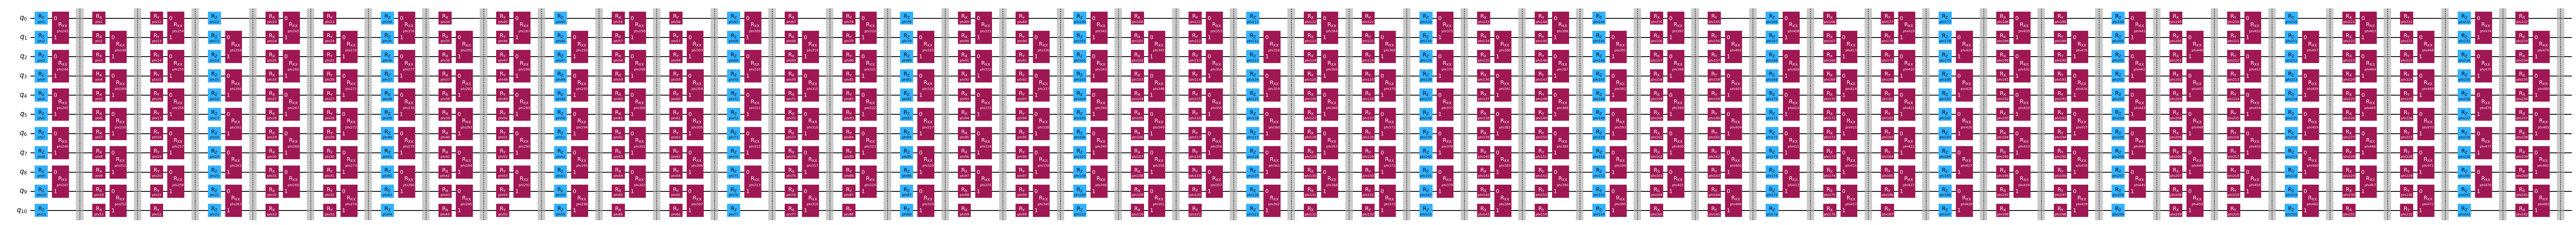

In [13]:
depth = 2 * num_qubits
ansatz = pauli_encoder.BrickWork(depth= depth, num_qubits=num_qubits)
ansatz.draw('mpl',fold=-1)

In [14]:
import warnings
warnings.filterwarnings("ignore")
from qiskit.primitives import BackendEstimator
from qiskit_aer import AerSimulator
backend = AerSimulator(method='automatic')

estimator = BackendEstimator(backend=backend, options={'shots': 1000})

In [15]:
pce = PauliCorrelationOptimizer(estimator=estimator, 
                                pauli_encoder=pauli_encoder,
                                depth=depth,
                                num_qubits=num_qubits,
                                k=k,
                                method='exact', 
                                loss_method='qubo',
                                qubo=qubo,
                                multi_op=True,
                                steps = 16)  # method can be 'exact' or 'quantum' and loss can 
                                                # be qubo or maxcut



In [16]:
maxiter = 50
from qiskit_algorithms.optimizers import SLSQP
optimizer = SLSQP(maxiter=maxiter)
params = np.random.rand(ansatz.num_parameters)
result=pce.optimize(optimizer,params)


Multi Reoptimization

--- Optimization Round 1 ---
Best QUBO cost: inf
QUBO cost: 3837081024.0
Improvement: inf
Improvement detected! Best QUBO cost updated: 3837081024.0
Consecutive no-improvement rounds: 0. Rounds remaining before stopping: 15.

--- Optimization Round 2 ---
Best QUBO cost: 3837081024.0
QUBO cost: 4647594352.0
No improvement detected.
No improvement in round 2.
Consecutive no-improvement rounds: 1. Rounds remaining before stopping: 14.

--- Optimization Round 3 ---
Best QUBO cost: 3837081024.0
QUBO cost: 3777588768.0
Improvement: 59492256.0
Improvement detected! Best QUBO cost updated: 3777588768.0
Consecutive no-improvement rounds: 0. Rounds remaining before stopping: 15.

--- Optimization Round 4 ---
Best QUBO cost: 3777588768.0
QUBO cost: 3694193734.0
Improvement: 83395034.0
Improvement detected! Best QUBO cost updated: 3694193734.0
Consecutive no-improvement rounds: 0. Rounds remaining before stopping: 15.

--- Optimization Round 5 ---
Best QUBO cost: 3694193734.0

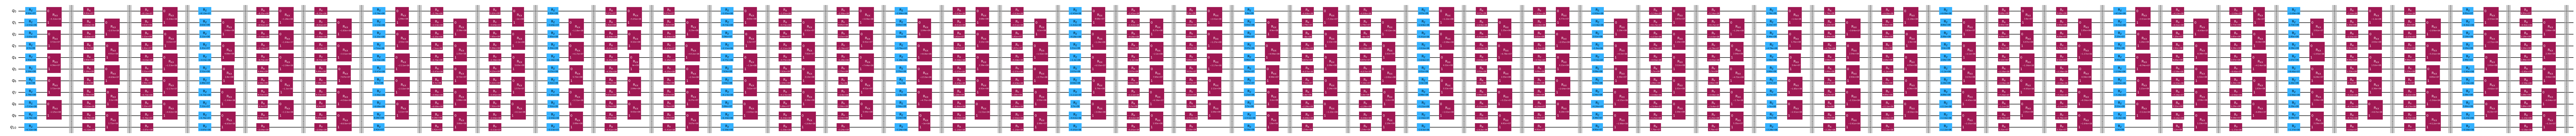

In [17]:
final_ansatz = pauli_encoder.BrickWork(depth= depth, num_qubits=num_qubits).assign_parameters(result)
final_ansatz.draw('mpl',fold=-1)

In [18]:
psi_final = Statevector(final_ansatz)

In [19]:
# Example usage:
# Assuming you have instantiated `psi_final`, `pauli_strings`, and `weight_matrix`
qubo_utility = QUBOUtility()
qubo_bitstring = qubo_utility.evaluate_sign_function(psi_final, pauli_strings)
qubo_cost = qubo.objective.evaluate(qubo_bitstring)

print(qubo_bitstring)
print(qubo_cost)

[1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
3277165700.0


In [20]:
result_initial = converter.interpret(qubo_bitstring)
initial_cost = qp.objective.evaluate(result_initial)
# check feasibility
inital_feasible = qp.get_feasibility_info(result_initial)[0]

print("Initial Knapsack score             :", initial_cost )
print("Initial Knapsack solution          :", result_initial)
print("Initial Knapsack solution feasible :", inital_feasible)

Initial Knapsack score             : 1373950.0
Initial Knapsack solution          : [1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0.
 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Initial Knapsack solution feasible : False


In [21]:
optimized_bitstring, final_cost = qubo_utility.bit_swap_search(qubo, bitstring=qubo_bitstring)
print("Optimized bitstring:", optimized_bitstring)
print("Final cost:", final_cost)

Starting cost: 3277165700.0
Bit flip: Improved solution by flipping bit 0: Cost = 3181774986.0
Bit flip: Improved solution by flipping bit 1: Cost = 3098319866.0
Bit flip: Improved solution by flipping bit 2: Cost = 3026736426.0
Bit flip: Improved solution by flipping bit 4: Cost = 2955163488.0
Bit flip: Improved solution by flipping bit 7: Cost = 2895508262.0
Bit flip: Improved solution by flipping bit 9: Cost = 2847775496.0
Bit flip: Improved solution by flipping bit 10: Cost = 2776232760.0
Bit flip: Improved solution by flipping bit 13: Cost = 2704720988.0
Bit flip: Improved solution by flipping bit 17: Cost = 2609413964.0
Bit flip: Improved solution by flipping bit 18: Cost = 2526002542.0
Bit flip: Improved solution by flipping bit 20: Cost = 2442591824.0
Bit flip: Improved solution by flipping bit 21: Cost = 2406831274.0
Bit flip: Improved solution by flipping bit 23: Cost = 2347248896.0
Bit flip: Improved solution by flipping bit 26: Cost = 2263832162.0
Bit flip: Improved solutio

In [22]:

result_initial = converter.interpret(optimized_bitstring)
initial_cost = qp.objective.evaluate(result_initial)
# check feasibility
inital_feasible = qp.get_feasibility_info(result_initial)[0]

print("Initial Knapsack score             :", initial_cost )
print("Initial Knapsack solution          :", result_initial)
print("Initial Knapsack solution feasible :", inital_feasible)

Initial Knapsack score             : 31734.0
Initial Knapsack solution          : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Initial Knapsack solution feasible : True
